# Análisis de N-gramas en Discursos Presidenciales
Este notebook presenta un análisis de n-gramas para comparar los discursos de los presidentes colombianos Iván Duque y Gustavo Petro ante la Asamblea General de las Naciones Unidas, enfocándonos exclusivamente en el análisis contextual mediante n-gramas.

## 1. Configuración del entorno
Preparamos los textos para su análisis, aplicando técnicas de limpieza y tokenización que nos permitirán trabajar con unidades lingüísticas discretas. El preprocesamiento es fundamental para obtener resultados de calidad en cualquier análisis de texto.

In [ ]:
# Instalación de bibliotecas necesarias
!pip install spacy matplotlib seaborn pandas numpy networkx wordcloud
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 41.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Importación de bibliotecas
import re
import requests
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Cargar modelo de spaCy para español
nlp = spacy.load('es_core_news_sm')

In [ ]:
# Crear lista de stopwords en español desde spaCy
stopwords_es = spacy.lang.es.stop_words.STOP_WORDS

In [ ]:
# Configuración de visualización
plt.style.use('ggplot')
sns.set(style='whitegrid')

## 2. Carga y preprocesamiento de los discursos
Cargamos los discursos y realizamos preprocesamiento básico para el análisis de n-gramas.

In [ ]:
# URLs de los discursos
url_duque = "https://raw.githubusercontent.com/Rodato/NLPforSocialSciences_Course/main/99.%20Data/discurso_onu_duque.txt"
url_petro = "https://raw.githubusercontent.com/Rodato/NLPforSocialSciences_Course/main/99.%20Data/discurso_onu_petro.txt"

# Cargamos los textos
response_duque = requests.get(url_duque)
response_duque.encoding = 'utf-8'
discurso_duque = response_duque.text

response_petro = requests.get(url_petro)
response_petro.encoding = 'utf-8'
discurso_petro = response_petro.text

# Mostramos los primeros párrafos
print("Primeras líneas del discurso de Duque:")
print("\n".join(discurso_duque.split('\n')[:3]))
print("\nPrimeras líneas del discurso de Petro:")
print("\n".join(discurso_petro.split('\n')[:3]))

Primeras líneas del discurso de Duque:
Nos encontramos de nuevo en este foro global que ha sido históricamente un espacio vital para el desarrollo del multilateralismo, la construcción global de la paz y de soluciones a las amenazas de nuestra casa común. Lo hacemos aun en medio de una pandemia cruel que golpea nuestros sistemas de salud, nuestras economías, nuestras conquistas de equidad y el avance de la Agenda 2030.
Por encima de cualquier consideración, nos encontramos una vez más en este histórico hemiciclo recordando la fragilidad del ser humano y, al mismo tiempo, reconociendo la grandeza y la condición de una raza humana que sabe sobreponerse a los grandes desafíos.
El covid-19 irrumpió de manera abrupta en nuestras vidas. Cambió nuestra cotidianidad, nuestra interacción y nos arrebató seres queridos. Este virus letal ha puesto a prueba nuestras emociones para entender, HOY MÁS QUE NUNCA, cuánto vale el abrazo de un padre y el de una madre, cuánto significa compartir en familia

In [ ]:
# Función para preprocesar texto con spaCy
def preprocesar_texto(texto, eliminar_stopwords=True, min_len=3):
    # Procesar el texto con spaCy
    doc = nlp(texto.lower())

    # Extraer tokens según criterios
    if eliminar_stopwords:
        tokens = [token.text for token in doc if not token.is_stop and not token.is_punct
                 and not token.is_digit and len(token.text) >= min_len]
    else:
        tokens = [token.text for token in doc if not token.is_punct and not token.is_digit]

    return tokens

In [ ]:
# Preprocesar los discursos con y sin stopwords
tokens_duque = preprocesar_texto(discurso_duque)
tokens_petro = preprocesar_texto(discurso_petro)
tokens_duque_con_stop = preprocesar_texto(discurso_duque, eliminar_stopwords=False)
tokens_petro_con_stop = preprocesar_texto(discurso_petro, eliminar_stopwords=False)

In [ ]:
# Información básica de los discursos
print("Tokens (sin stopwords) en discurso de Duque:", len(tokens_duque))
print("Tokens (sin stopwords) en discurso de Petro:", len(tokens_petro))
print("Palabras únicas (sin stopwords) en discurso de Duque:", len(set(tokens_duque)))
print("Palabras únicas (sin stopwords) en discurso de Petro:", len(set(tokens_petro)))

Tokens (sin stopwords) en discurso de Duque: 1185
Tokens (sin stopwords) en discurso de Petro: 895
Palabras únicas (sin stopwords) en discurso de Duque: 782
Palabras únicas (sin stopwords) en discurso de Petro: 545


## 3. Análisis de unigramas
Descripción: Los unigramas son secuencias de una sola palabra. En esta sección analizamos las palabras individuales más frecuentes en cada discurso, lo que nos permite identificar los temas clave y el vocabulario característico de cada presidente. Este análisis básico constituye el primer paso para entender el contenido temático de los textos.

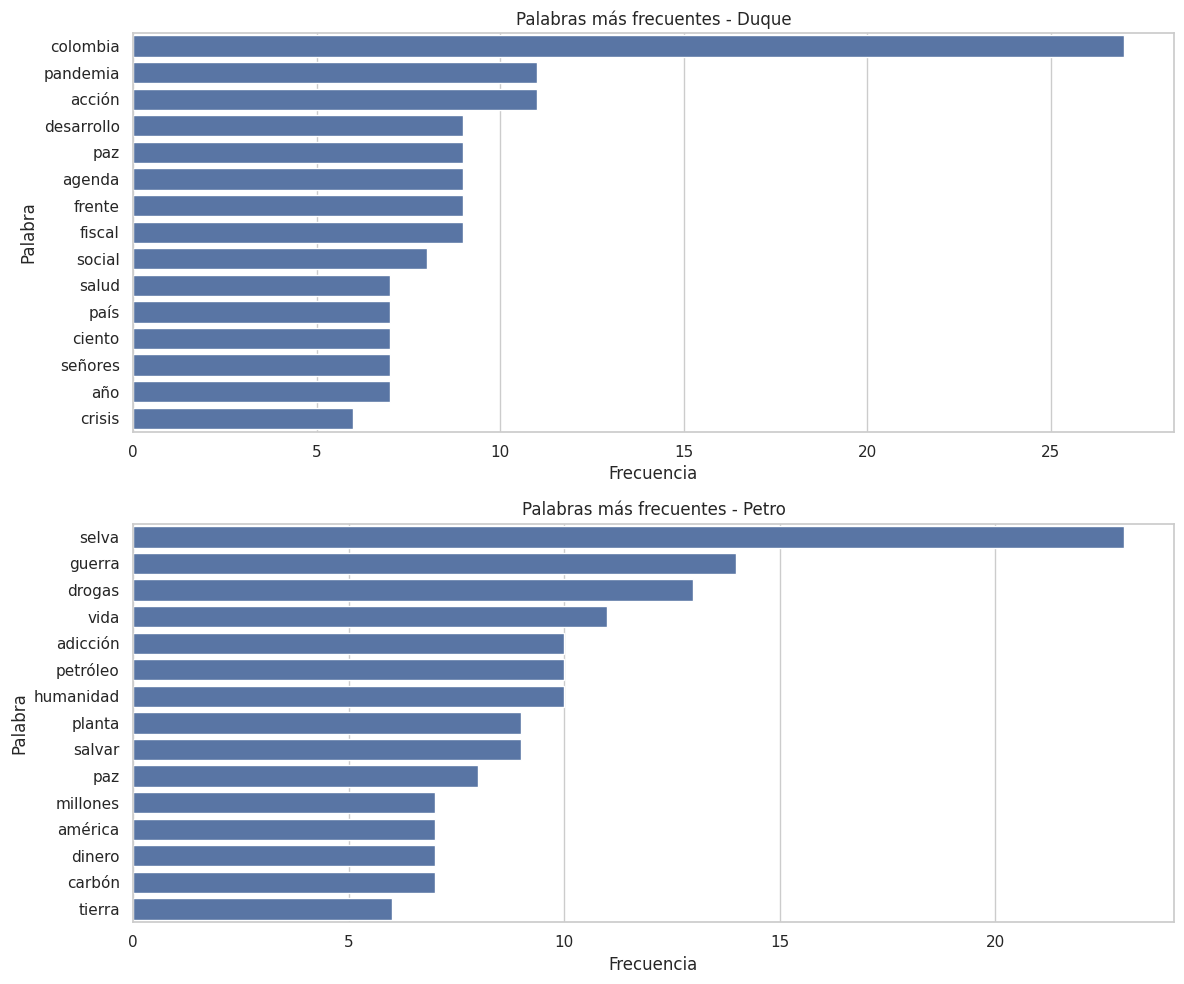

In [ ]:
# Función para obtener las palabras más frecuentes
def palabras_frecuentes(tokens, n=20):
    contador = Counter(tokens)
    return contador.most_common(n)

# Obtener palabras frecuentes para cada discurso
palabras_freq_duque = palabras_frecuentes(tokens_duque)
palabras_freq_petro = palabras_frecuentes(tokens_petro)

# Crear DataFrames
df_freq_duque = pd.DataFrame(palabras_freq_duque, columns=['Palabra', 'Frecuencia'])
df_freq_petro = pd.DataFrame(palabras_freq_petro, columns=['Palabra', 'Frecuencia'])

# Visualización de palabras más frecuentes
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='Frecuencia', y='Palabra', data=df_freq_duque.head(15))
plt.title('Palabras más frecuentes - Duque')

plt.subplot(2, 1, 2)
sns.barplot(x='Frecuencia', y='Palabra', data=df_freq_petro.head(15))
plt.title('Palabras más frecuentes - Petro')

plt.tight_layout()
plt.show()

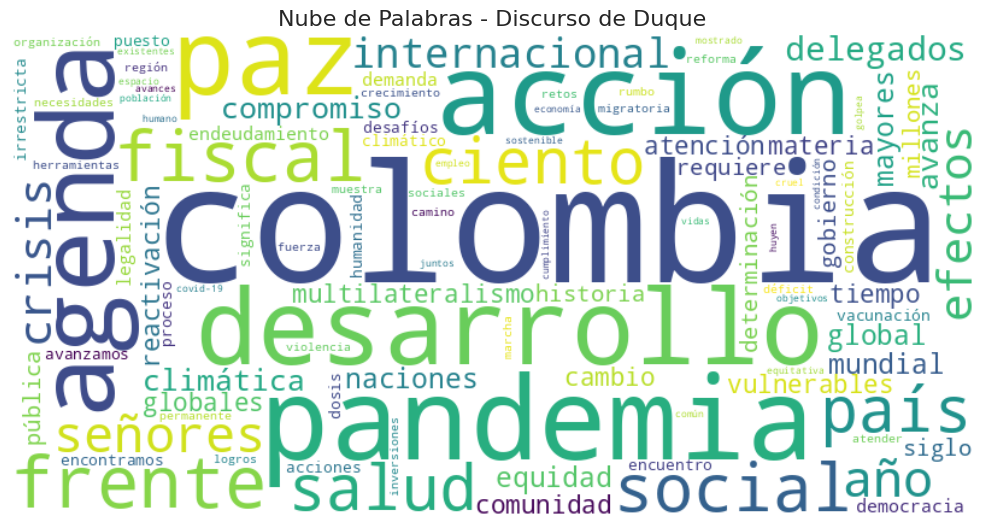

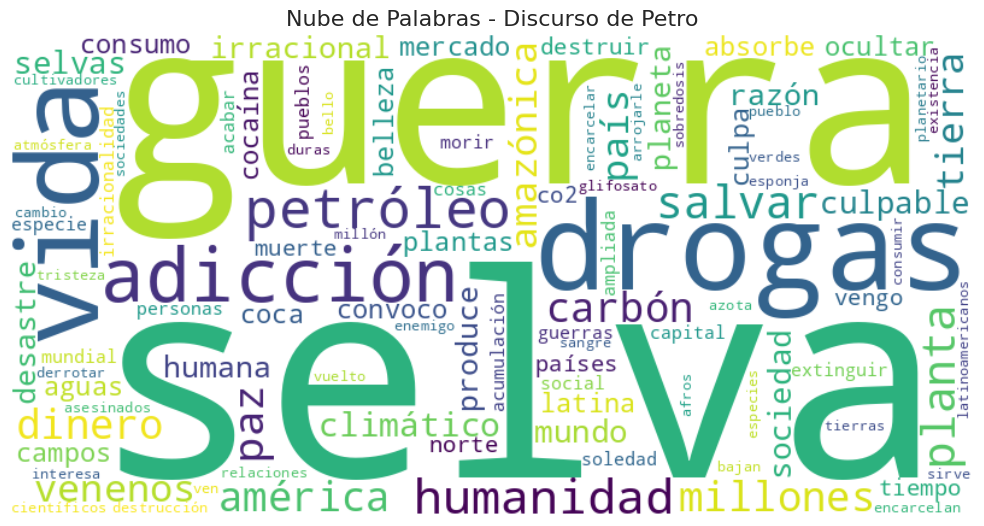

In [ ]:
# Nubes de palabras
def crear_nube_palabras(tokens, titulo, max_words=100):
    # Crear un diccionario de frecuencias
    freq_dict = dict(Counter(tokens).most_common(max_words))

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        contour_width=1,
        contour_color='steelblue'
    ).generate_from_frequencies(freq_dict)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=16)
    plt.tight_layout()
    plt.show()

crear_nube_palabras(tokens_duque, 'Nube de Palabras - Discurso de Duque')
crear_nube_palabras(tokens_petro, 'Nube de Palabras - Discurso de Petro')

## 4. Análisis de bigramas
Los bigramas son pares de palabras consecutivas que nos permiten capturar contexto local. Esta sección explora las combinaciones de dos palabras más frecuentes, revelando frases comunes y asociaciones que no son visibles al analizar palabras aisladas. Los bigramas son fundamentales para entender cómo se construyen expresiones más complejas.

In [ ]:
# Función para obtener n-gramas con spaCy
def obtener_ngramas(tokens, n=2):
    """Genera n-gramas a partir de una lista de tokens."""
    ngramas = []
    for i in range(len(tokens) - n + 1):
        ngrama = tuple(tokens[i:i+n])
        ngramas.append(ngrama)
    return ngramas

In [ ]:
# Obtener bigramas (con y sin stopwords)
bigramas_duque = obtener_ngramas(tokens_duque, n=2)
bigramas_petro = obtener_ngramas(tokens_petro, n=2)
bigramas_duque_con_stop = obtener_ngramas(tokens_duque_con_stop, n=2)
bigramas_petro_con_stop = obtener_ngramas(tokens_petro_con_stop, n=2)

In [ ]:
# Contar frecuencia de bigramas
contador_bigramas_duque = Counter(bigramas_duque)
contador_bigramas_petro = Counter(bigramas_petro)
contador_bigramas_duque_con_stop = Counter(bigramas_duque_con_stop)
contador_bigramas_petro_con_stop = Counter(bigramas_petro_con_stop)

In [ ]:
# Crear DataFrames para bigramas (sin stopwords)
df_bigramas_duque = pd.DataFrame(contador_bigramas_duque.most_common(20),
                                columns=['Bigrama', 'Frecuencia'])
df_bigramas_duque['Bigrama'] = df_bigramas_duque['Bigrama'].apply(lambda x: ' + '.join(x))

df_bigramas_petro = pd.DataFrame(contador_bigramas_petro.most_common(20),
                               columns=['Bigrama', 'Frecuencia'])
df_bigramas_petro['Bigrama'] = df_bigramas_petro['Bigrama'].apply(lambda x: ' + '.join(x))

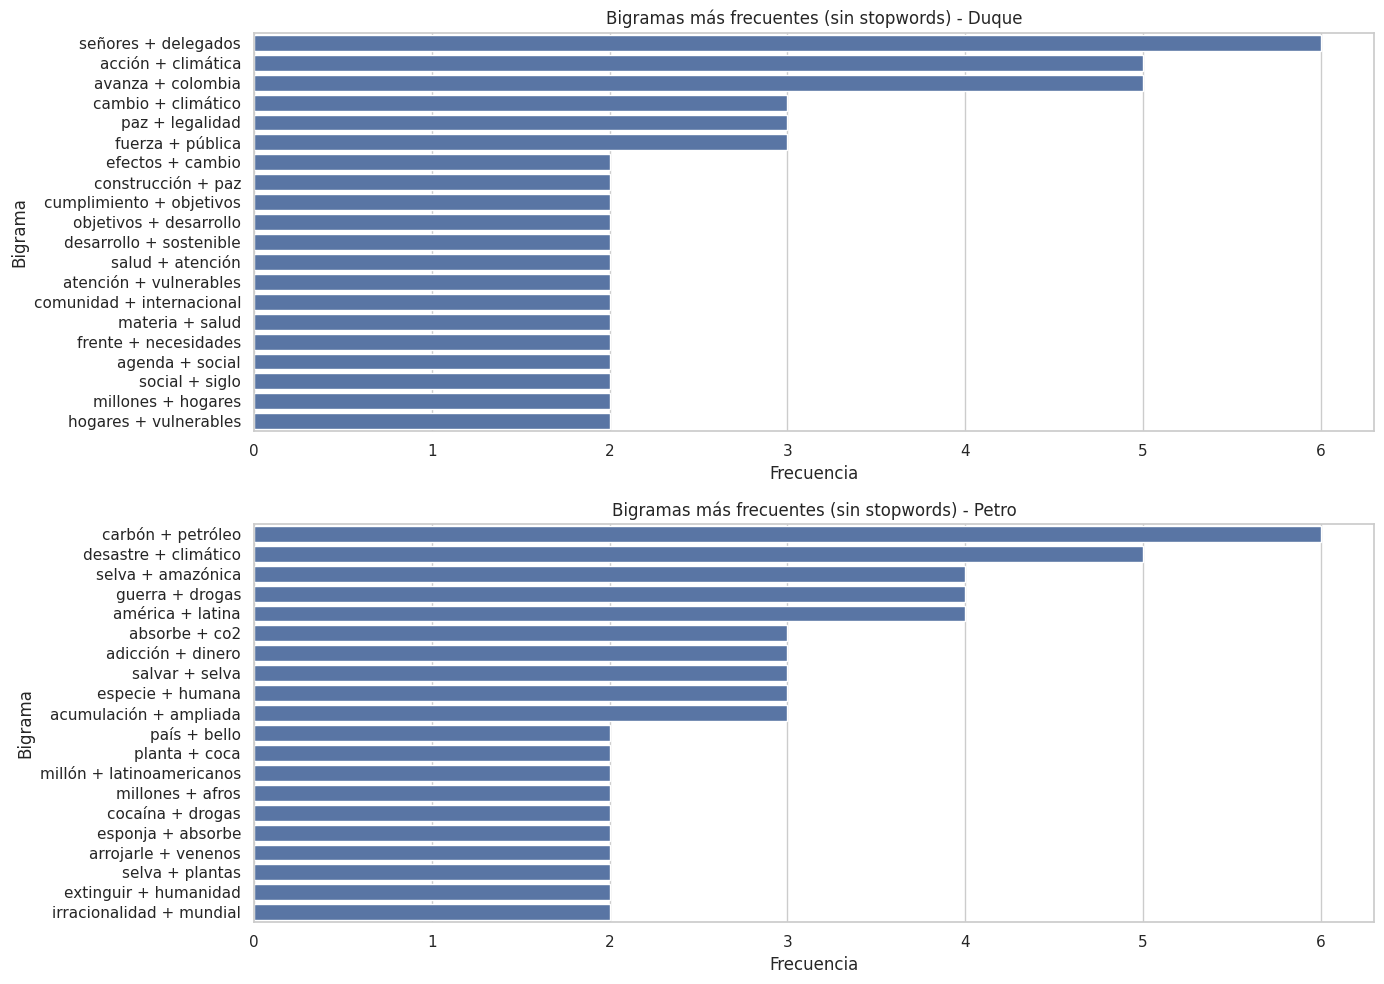

In [ ]:
# Visualizar bigramas (sin stopwords)
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='Frecuencia', y='Bigrama', data=df_bigramas_duque)
plt.title('Bigramas más frecuentes (sin stopwords) - Duque')

plt.subplot(2, 1, 2)
sns.barplot(x='Frecuencia', y='Bigrama', data=df_bigramas_petro)
plt.title('Bigramas más frecuentes (sin stopwords) - Petro')

plt.tight_layout()
plt.show()

In [ ]:
# Crear DataFrames para bigramas (con stopwords)
df_bigramas_duque_con_stop = pd.DataFrame(contador_bigramas_duque_con_stop.most_common(20),
                                        columns=['Bigrama', 'Frecuencia'])
df_bigramas_duque_con_stop['Bigrama'] = df_bigramas_duque_con_stop['Bigrama'].apply(lambda x: ' + '.join(x))

df_bigramas_petro_con_stop = pd.DataFrame(contador_bigramas_petro_con_stop.most_common(20),
                                       columns=['Bigrama', 'Frecuencia'])
df_bigramas_petro_con_stop['Bigrama'] = df_bigramas_petro_con_stop['Bigrama'].apply(lambda x: ' + '.join(x))

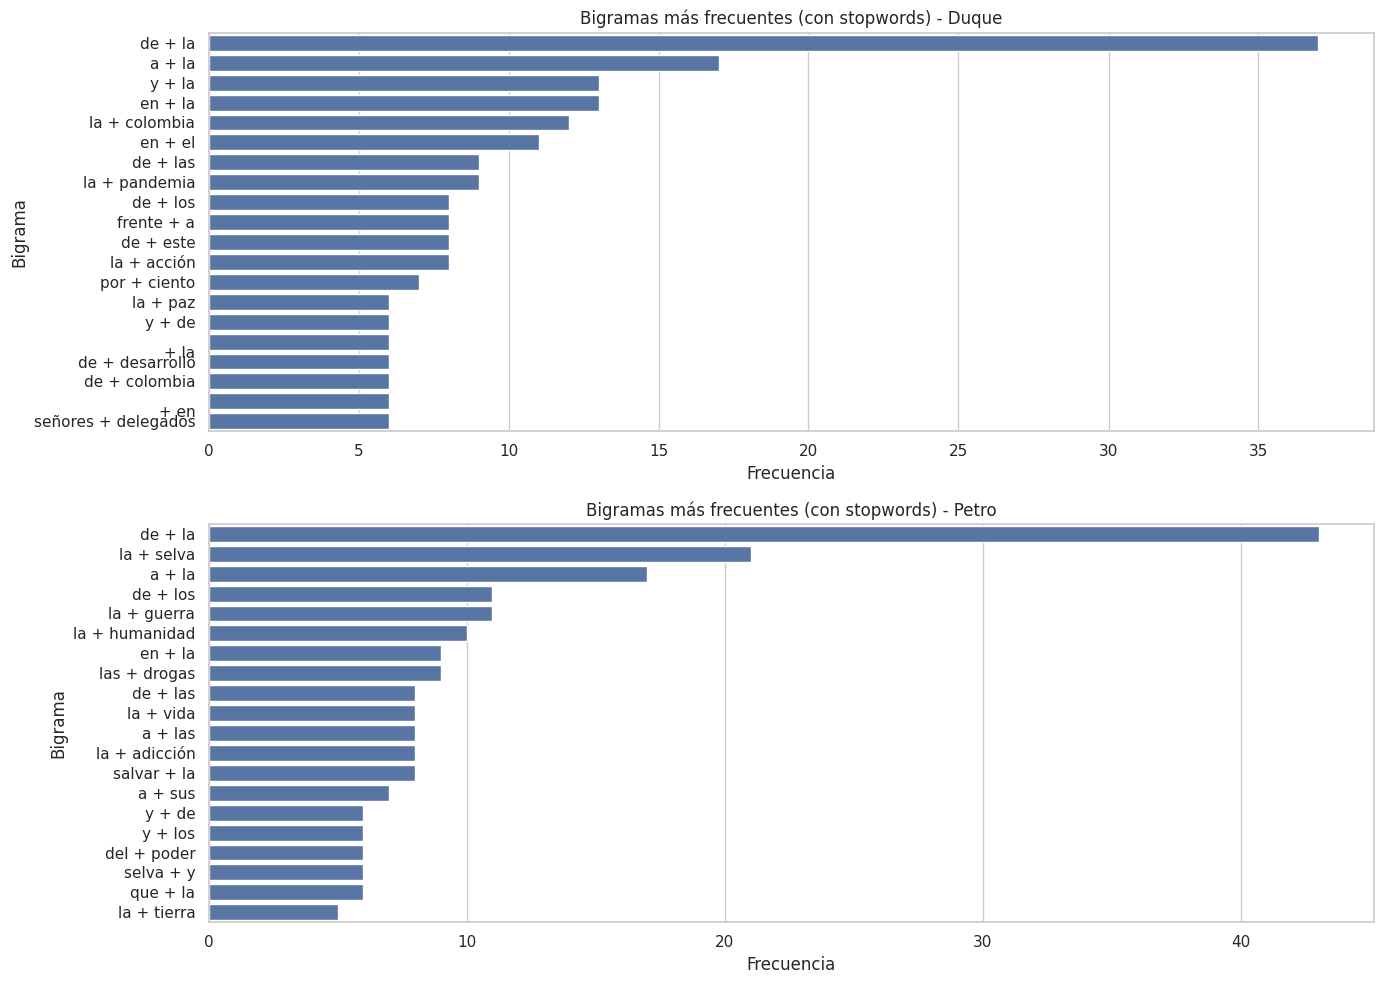

In [ ]:
# Visualizar bigramas (con stopwords)
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='Frecuencia', y='Bigrama', data=df_bigramas_duque_con_stop)
plt.title('Bigramas más frecuentes (con stopwords) - Duque')

plt.subplot(2, 1, 2)
sns.barplot(x='Frecuencia', y='Bigrama', data=df_bigramas_petro_con_stop)
plt.title('Bigramas más frecuentes (con stopwords) - Petro')

plt.tight_layout()
plt.show()

## 5. Análisis de trigramas
Los trigramas (secuencias de tres palabras consecutivas) nos permiten capturar expresiones más complejas y patrones fraseológicos característicos. Este nivel de análisis revela construcciones lingüísticas distintivas de cada presidente y puede mostrar elementos estilísticos que definen su retórica.

In [ ]:
# Obtener trigramas
trigramas_duque = obtener_ngramas(tokens_duque_con_stop, n=3)
trigramas_petro = obtener_ngramas(tokens_petro_con_stop, n=3)

# Contar frecuencia de trigramas
contador_trigramas_duque = Counter(trigramas_duque)
contador_trigramas_petro = Counter(trigramas_petro)

In [ ]:
# Crear DataFrames para trigramas
df_trigramas_duque = pd.DataFrame(contador_trigramas_duque.most_common(15),
                                 columns=['Trigrama', 'Frecuencia'])
df_trigramas_duque['Trigrama'] = df_trigramas_duque['Trigrama'].apply(lambda x: ' + '.join(x))

df_trigramas_petro = pd.DataFrame(contador_trigramas_petro.most_common(15),
                                columns=['Trigrama', 'Frecuencia'])
df_trigramas_petro['Trigrama'] = df_trigramas_petro['Trigrama'].apply(lambda x: ' + '.join(x))

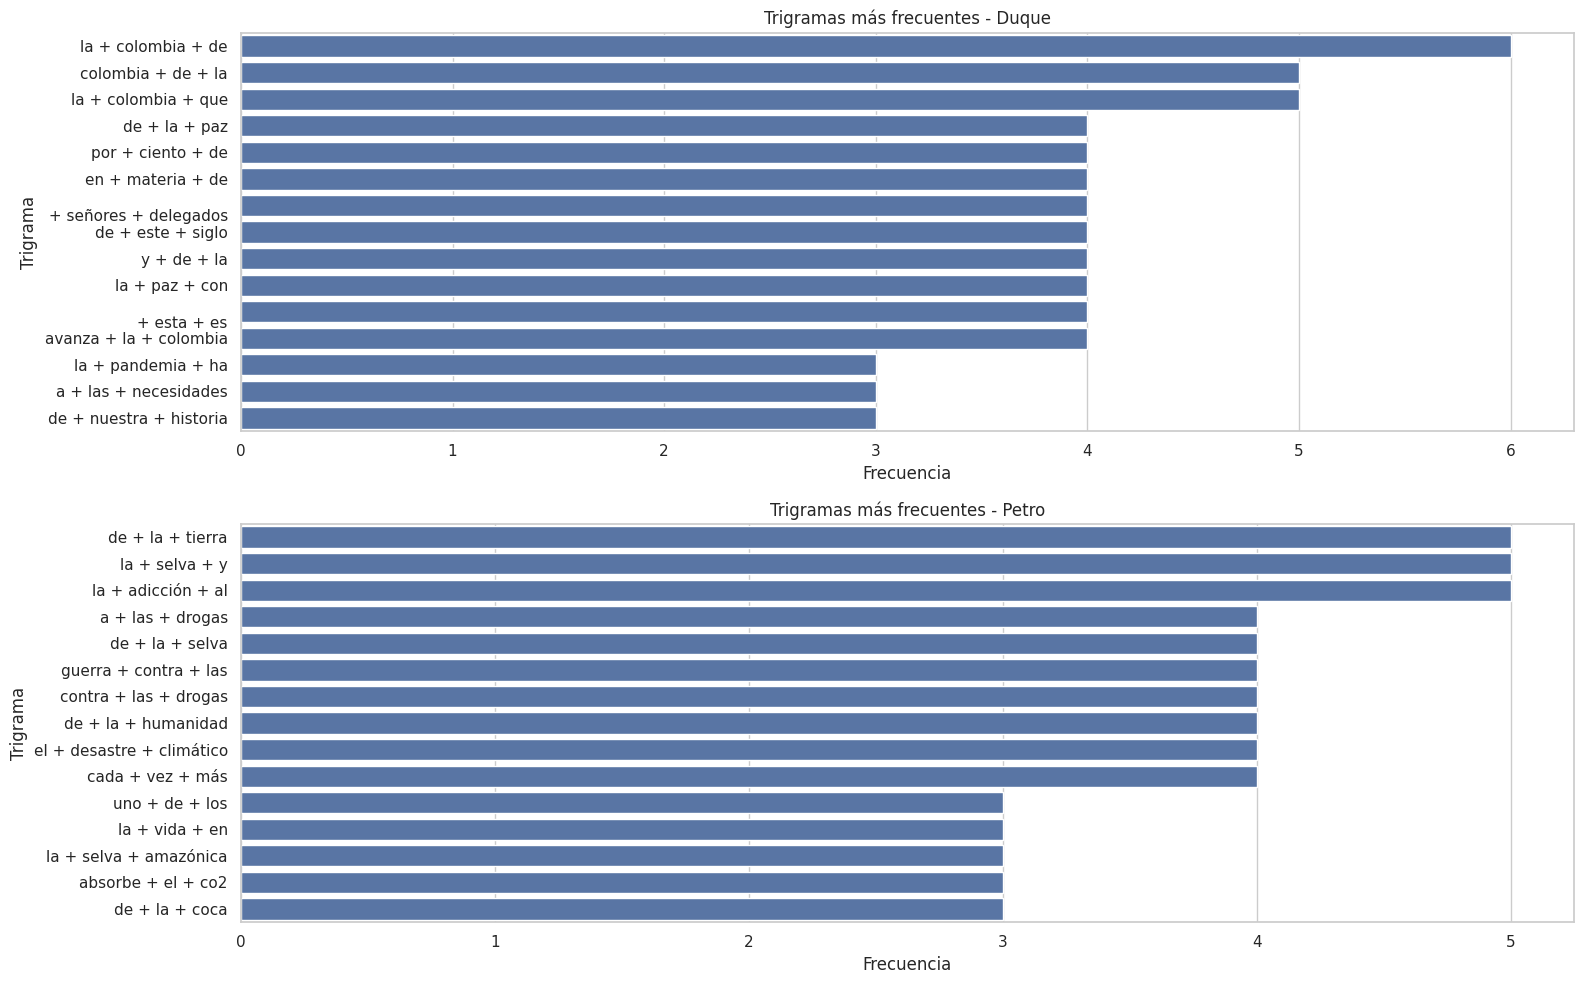

In [ ]:
# Visualizar trigramas
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='Frecuencia', y='Trigrama', data=df_trigramas_duque)
plt.title('Trigramas más frecuentes - Duque')

plt.subplot(2, 1, 2)
sns.barplot(x='Frecuencia', y='Trigrama', data=df_trigramas_petro)
plt.title('Trigramas más frecuentes - Petro')

plt.tight_layout()
plt.show()

### Encontremos los trigramas sin stopwords

## 6. Comparación de n-gramas entre discursos

Esta sección compara directamente los patrones de n-gramas entre ambos discursos, identificando las expresiones que caracterizan distintivamente a cada presidente. Este análisis comparativo revela diferencias en enfoque temático, estilo retórico y construcciones lingüísticas preferidas.

In [ ]:
# Función para calcular frecuencia relativa (normalizada por tamaño del texto)
def frecuencia_relativa(contador, total_tokens):
    return {' + '.join(ngram): freq/total_tokens for ngram, freq in contador.items()}

In [ ]:
# Calcular frecuencias relativas para bigramas
bigramas_rel_duque = frecuencia_relativa(contador_bigramas_duque, len(tokens_duque))
bigramas_rel_petro = frecuencia_relativa(contador_bigramas_petro, len(tokens_petro))

# Unir todos los bigramas de ambos discursos
todos_bigramas = set(bigramas_rel_duque.keys()) | set(bigramas_rel_petro.keys())

In [ ]:
# Crear DataFrame comparativo
comparacion_bigramas = []
for bigrama in todos_bigramas:
    freq_duque = bigramas_rel_duque.get(bigrama, 0)
    freq_petro = bigramas_rel_petro.get(bigrama, 0)
    diferencia = freq_petro - freq_duque
    ratio = freq_petro / freq_duque if freq_duque > 0 else float('inf') if freq_petro > 0 else 0
    comparacion_bigramas.append({
        'Bigrama': bigrama,
        'Frecuencia_Duque': freq_duque,
        'Frecuencia_Petro': freq_petro,
        'Diferencia': diferencia,
        'Ratio_Petro_Duque': ratio
    })

In [ ]:
df_comparacion = pd.DataFrame(comparacion_bigramas)

In [ ]:
# Ordenar por diferencia absoluta
df_mas_petro = df_comparacion.sort_values('Diferencia', ascending=False).head(10)
df_mas_duque = df_comparacion.sort_values('Diferencia', ascending=True).head(10)

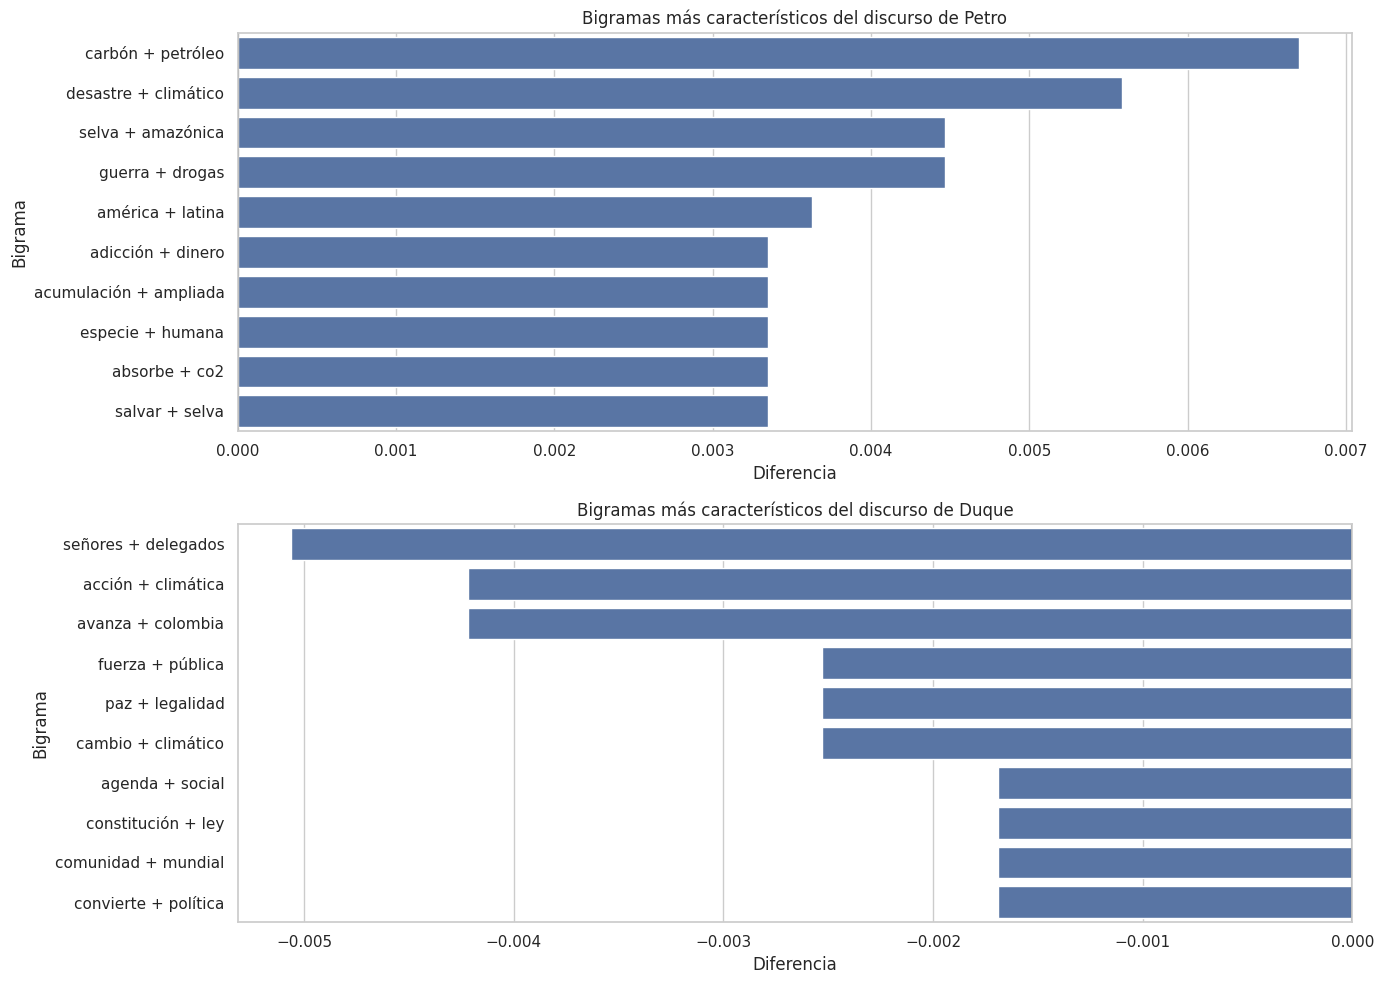

In [ ]:
# Visualizar bigramas característicos
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='Diferencia', y='Bigrama', data=df_mas_petro)
plt.title('Bigramas más característicos del discurso de Petro')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)

plt.subplot(2, 1, 2)
sns.barplot(x='Diferencia', y='Bigrama', data=df_mas_duque)
plt.title('Bigramas más característicos del discurso de Duque')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

# 7. Análisis de ventanas contextuales

Las ventanas contextuales nos permiten examinar qué palabras aparecen cerca de términos clave específicos. Esta técnica revela el entorno lingüístico de conceptos importantes en cada discurso, mostrando cómo se construyen significados asociados a palabras centrales como "paz", "selva" o "pandemia".

In [ ]:
# Función para extraer ventanas contextuales con spaCy
def ventana_contextual(tokens, palabra_clave, tamano_ventana=3):
    """Extrae palabras en una ventana alrededor de palabras clave."""
    contextos = []
    indices = [i for i, token in enumerate(tokens) if token == palabra_clave]

    for idx in indices:
        inicio = max(0, idx - tamano_ventana)
        fin = min(len(tokens), idx + tamano_ventana + 1)
        contexto = tokens[inicio:idx] + tokens[idx+1:fin]
        contextos.extend(contexto)

    return contextos

In [ ]:
# Definir palabras clave para análisis contextual
palabras_clave_duque = ['colombia', 'paz', 'pandemia', 'vacunación']
palabras_clave_petro = ['selva', 'coca', 'drogas', 'guerra']

# Extraer y analizar contextos
contextos_duque = {}
for palabra in palabras_clave_duque:
    contextos_duque[palabra] = ventana_contextual(tokens_duque_con_stop, palabra)

contextos_petro = {}
for palabra in palabras_clave_petro:
    contextos_petro[palabra] = ventana_contextual(tokens_petro_con_stop, palabra)

In [ ]:
# Filtrar stopwords para visualización usando spaCy
for presidente, contextos in [('Duque', contextos_duque), ('Petro', contextos_petro)]:
    for palabra in contextos:
        if contextos[palabra]:
            contextos[palabra] = [t for t in contextos[palabra] if t not in stopwords_es and len(t) >= 3]

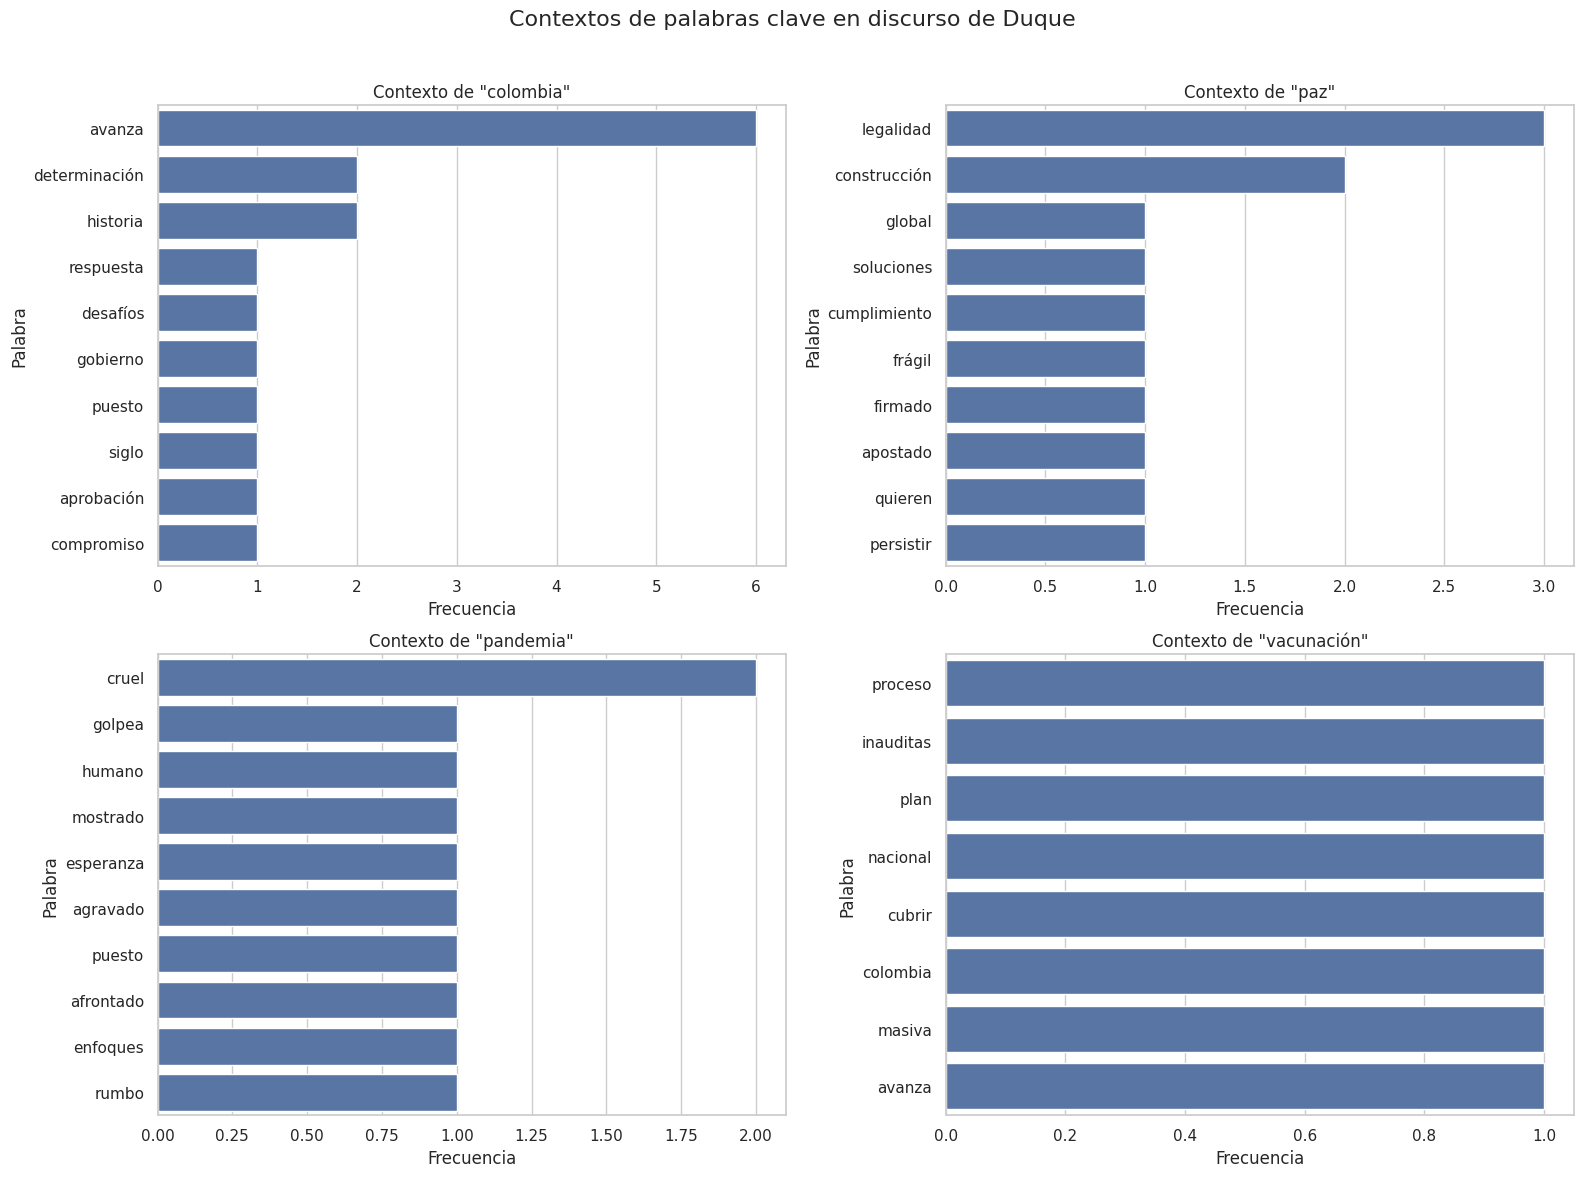

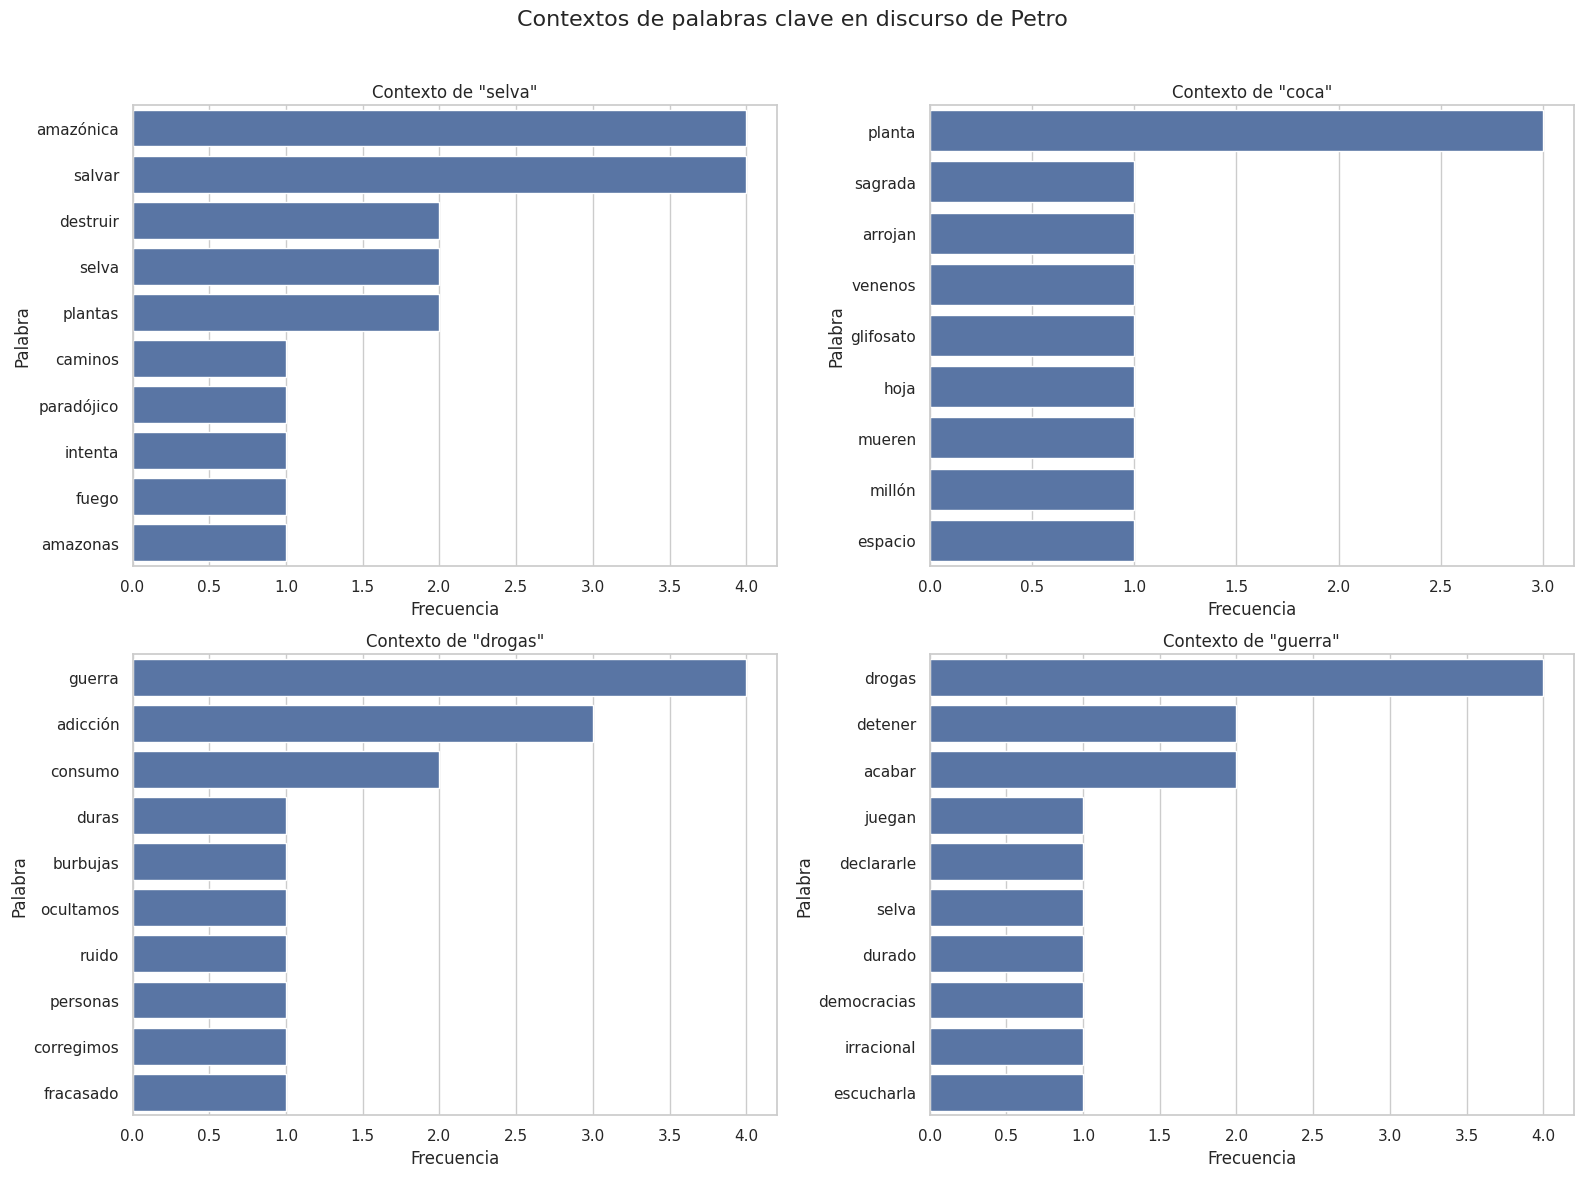

In [ ]:
# Visualizar los contextos más frecuentes con filtrado spaCy
for presidente, contextos, titulo in [
    ('Duque', contextos_duque, 'Contextos de palabras clave en discurso de Duque'),
    ('Petro', contextos_petro, 'Contextos de palabras clave en discurso de Petro')
]:
    plt.figure(figsize=(16, 12))
    i = 1
    for palabra, tokens_contexto in contextos.items():
        if not tokens_contexto:  # Si no hay contextos
            continue

        contador = Counter(tokens_contexto)
        df_contexto = pd.DataFrame(contador.most_common(10), columns=['Palabra', 'Frecuencia'])

        if not df_contexto.empty:
            plt.subplot(2, 2, i)
            sns.barplot(x='Frecuencia', y='Palabra', data=df_contexto)
            plt.title(f'Contexto de "{palabra}"')
            i += 1

    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

## 8. Redes de co-ocurrencia basadas en n-gramas
Las redes de co-ocurrencia visualizan las relaciones entre palabras basadas en su aparición conjunta en el texto. Esta técnica avanzada nos permite identificar clusters temáticos y patrones de asociación que revelan la estructura conceptual subyacente en cada discurso.

In [ ]:
# Función para crear red de co-ocurrencia
def red_coocurrencia_ngramas(tokens, n=2, min_freq=2, max_nodes=30):
    # Obtener n-gramas y sus frecuencias
    n_grams = obtener_ngramas(tokens, n)
    contador = Counter(n_grams)

    # Filtrar por frecuencia mínima
    ngramas_filtrados = {ng: freq for ng, freq in contador.items() if freq >= min_freq}

    # Crear grafo
    G = nx.Graph()

    # Añadir aristas para cada n-grama
    for ngram, freq in ngramas_filtrados.items():
        if n == 2:  # bigrama
            G.add_edge(ngram[0], ngram[1], weight=freq)
        else:  # n > 2
            for i in range(len(ngram)-1):
                for j in range(i+1, len(ngram)):
                    if G.has_edge(ngram[i], ngram[j]):
                        G[ngram[i]][ngram[j]]['weight'] += freq
                    else:
                        G.add_edge(ngram[i], ngram[j], weight=freq)

    # Limitar número de nodos
    if len(G.nodes()) > max_nodes:
        # Ordenar nodos por grado
        sorted_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:max_nodes]
        nodes_to_keep = [node for node, degree in sorted_nodes]
        G = G.subgraph(nodes_to_keep)

    return G

In [ ]:
# Crear redes de co-ocurrencia
# Filtramos stopwords pero conservamos palabras cortas para mejorar la red
tokens_duque_red = [t for t in tokens_duque_con_stop if t not in stopwords_es or len(t) > 3]
tokens_petro_red = [t for t in tokens_petro_con_stop if t not in stopwords_es or len(t) > 3]

G_duque = red_coocurrencia_ngramas(tokens_duque_red, n=2, min_freq=3, max_nodes=25)
G_petro = red_coocurrencia_ngramas(tokens_petro_red, n=2, min_freq=3, max_nodes=25)

In [ ]:
# Función para visualizar red
def visualizar_red_ngramas(G, titulo, figsize=(12, 10)):
    plt.figure(figsize=figsize)

    # Posición de los nodos
    pos = nx.spring_layout(G, seed=42, k=0.3)

    # Obtener pesos para el grosor de las aristas
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(weights) if weights else 1
    normalized_weights = [3 * w / max_weight for w in weights]

    # Obtener tamaños de nodos basados en su centralidad
    node_size = [300 * nx.degree_centrality(G)[node] + 50 for node in G.nodes()]

    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='skyblue', alpha=0.8)

    # Dibujar aristas
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.5, edge_color='gray')

    # Dibujar etiquetas
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    plt.title(titulo, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

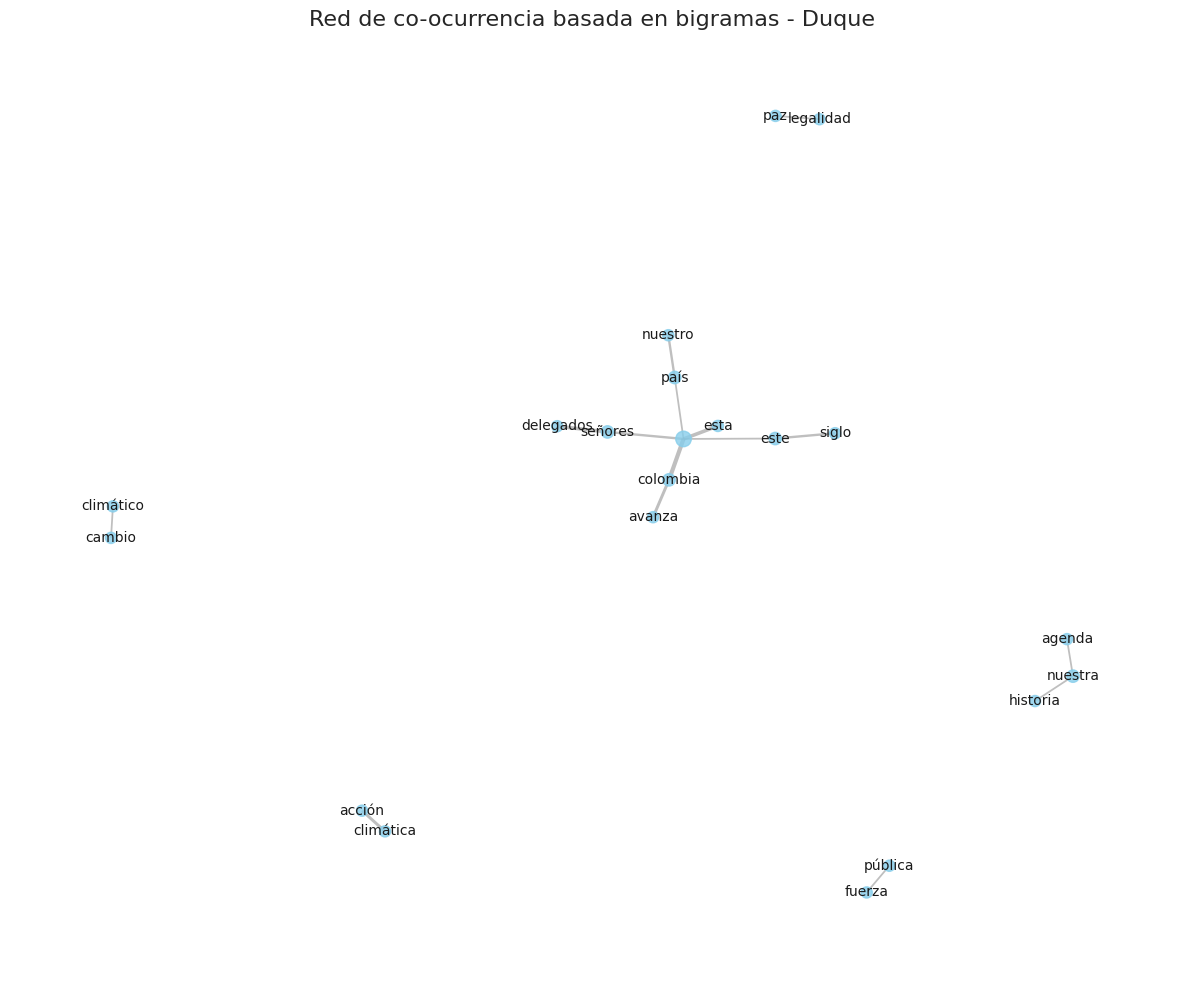

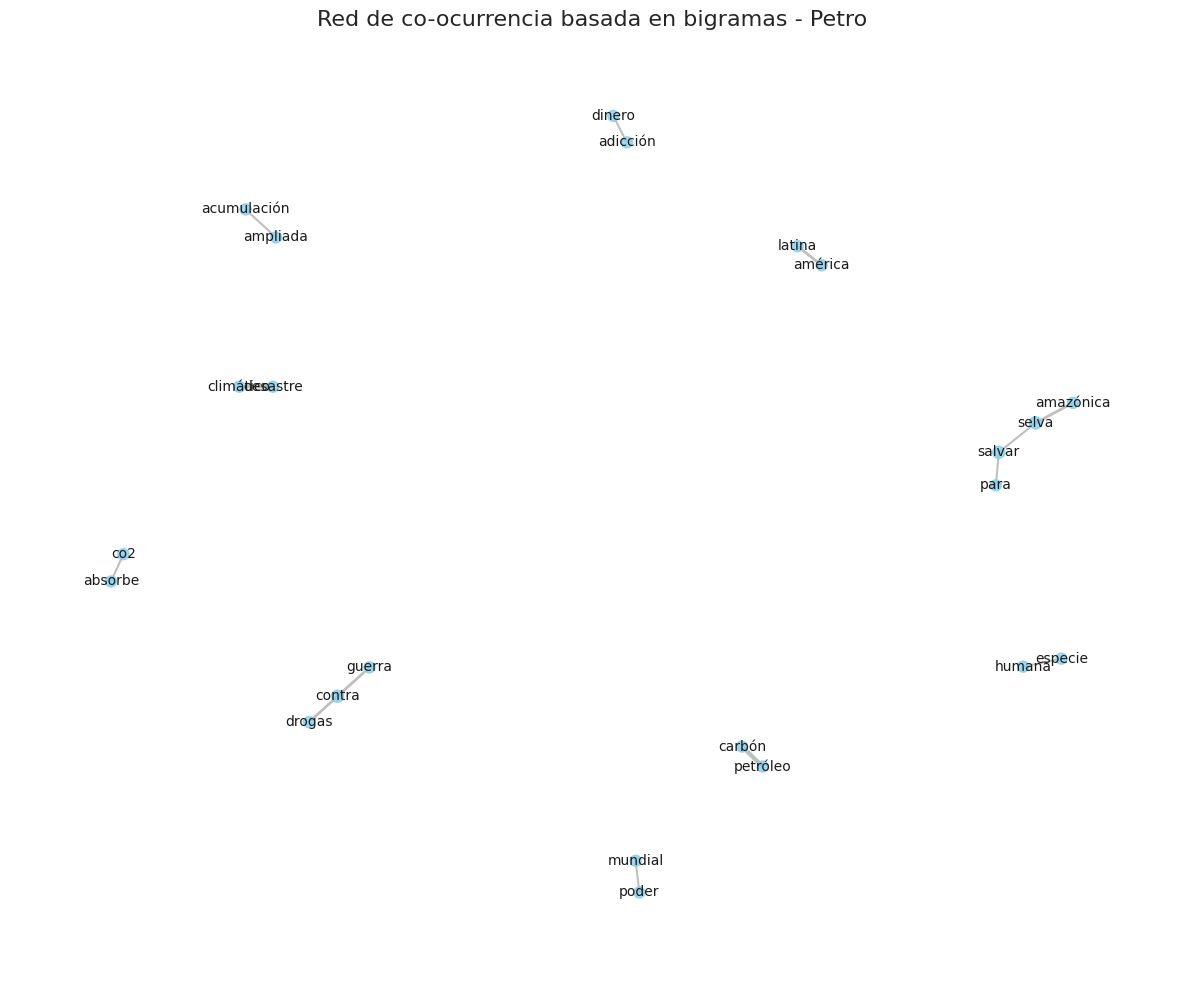

In [ ]:
# Visualizar redes
visualizar_red_ngramas(G_duque, 'Red de co-ocurrencia basada en bigramas - Duque')
visualizar_red_ngramas(G_petro, 'Red de co-ocurrencia basada en bigramas - Petro')

## 9. Skip-gramas: N-gramas con saltos
Los skip-gramas son n-gramas no consecutivos que permiten capturar relaciones a mayor distancia. Esta técnica complementa a los n-gramas tradicionales, identificando asociaciones entre palabras que no están inmediatamente adyacentes pero mantienen relaciones semánticas importantes en el texto.

In [ ]:
# Función para generar skip-gramas usando spaCy
def generar_skipgrams(tokens, n=2, k=2):
    """Genera n-gramas con saltos de hasta k posiciones."""
    skipgrams = []
    for i in range(len(tokens) - n + 1):
        # Para cada posición inicial
        for skip in range(1, k + 1):
            # Para cada tamaño de salto hasta k
            if i + n + skip - 1 < len(tokens):
                # Si hay suficientes tokens
                skipgram = (tokens[i], tokens[i + n + skip - 1])
                skipgrams.append(skipgram)
    return skipgrams

In [ ]:
# Generar skip-gramas usando spaCy
skipgrams_duque = generar_skipgrams(tokens_duque, n=2, k=2)
skipgrams_petro = generar_skipgrams(tokens_petro, n=2, k=2)

# Contar frecuencias
contador_skipgrams_duque = Counter(skipgrams_duque)
contador_skipgrams_petro = Counter(skipgrams_petro)

# Crear DataFrames
df_skipgrams_duque = pd.DataFrame(contador_skipgrams_duque.most_common(15),
                                 columns=['Skip-grama', 'Frecuencia'])
df_skipgrams_duque['Skip-grama'] = df_skipgrams_duque['Skip-grama'].apply(lambda x: ' -- '.join(x))

df_skipgrams_petro = pd.DataFrame(contador_skipgrams_petro.most_common(15),
                                columns=['Skip-grama', 'Frecuencia'])
df_skipgrams_petro['Skip-grama'] = df_skipgrams_petro['Skip-grama'].apply(lambda x: ' -- '.join(x))

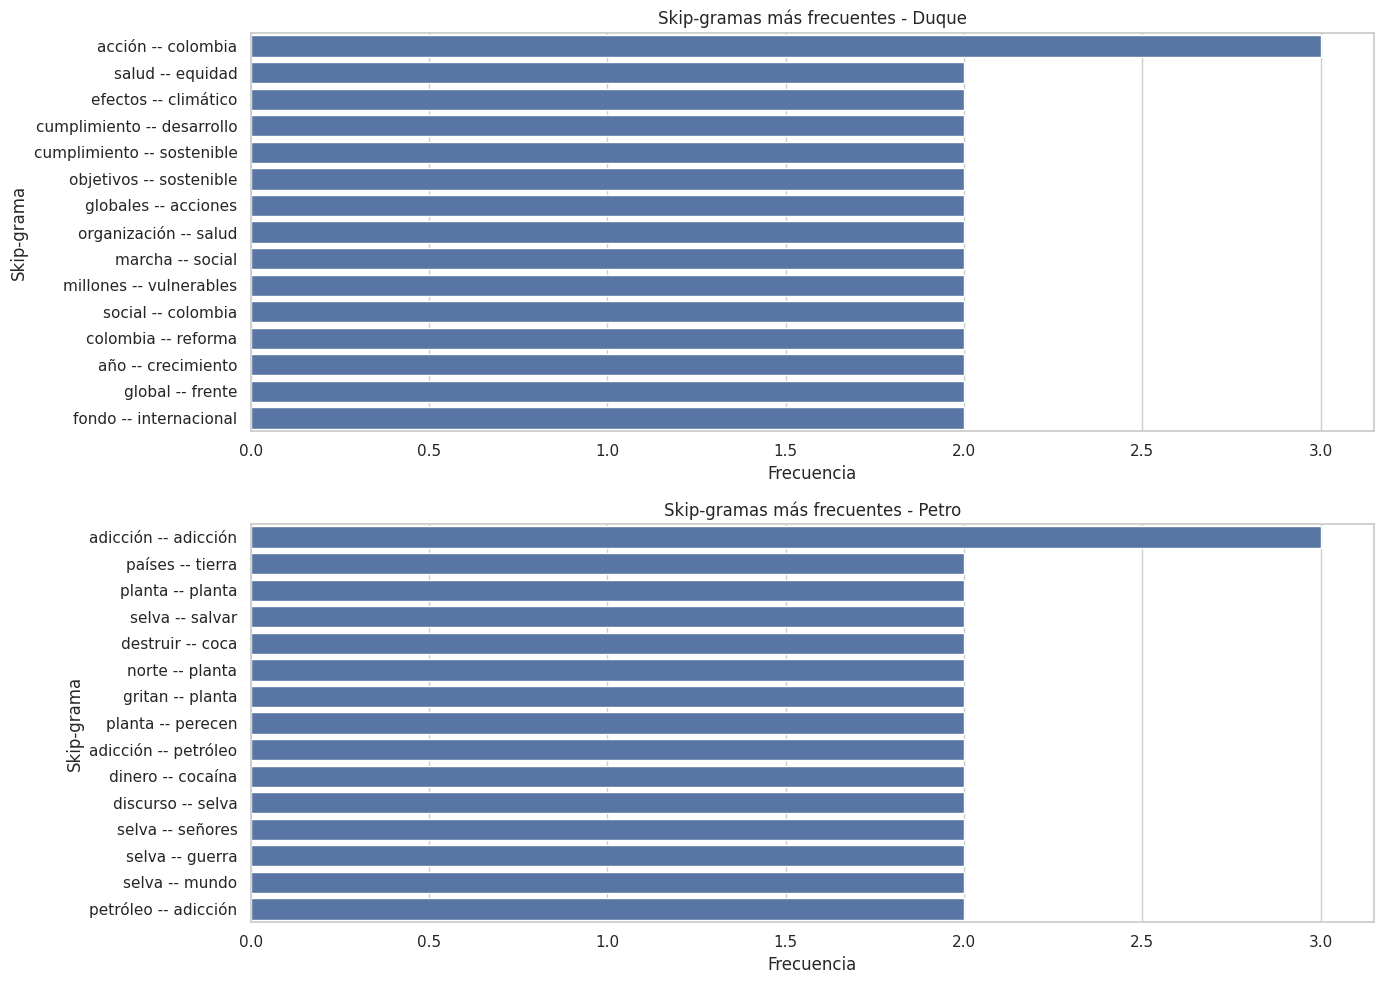

In [ ]:
# Visualizar skip-gramas
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='Frecuencia', y='Skip-grama', data=df_skipgrams_duque)
plt.title('Skip-gramas más frecuentes - Duque')

plt.subplot(2, 1, 2)
sns.barplot(x='Frecuencia', y='Skip-grama', data=df_skipgrams_petro)
plt.title('Skip-gramas más frecuentes - Petro')

plt.tight_layout()
plt.show()

## 10. Análisis de dependencias sintácticas con spaCy
Aprovechando el analizador sintáctico de spaCy, exploramos las relaciones gramaticales entre palabras, visualizando la estructura de dependencias en oraciones representativas. Este análisis revela patrones en la construcción de frases y la complejidad sintáctica característica de cada discurso.

In [ ]:
# Función para extraer patrones de dependencia sintáctica
def patrones_dependencia(texto, n_oraciones=5):
    doc = nlp(texto)

    # Limitar a un número manejable de oraciones para visualización
    oraciones = list(doc.sents)[:n_oraciones]

    patrones = []
    for oracion in oraciones:
        for token in oracion:
            if token.dep_ != "punct" and token.head.i != token.i:  # Excluir puntuación y raíz
                patrones.append({
                    'palabra': token.text,
                    'categoria': token.pos_,
                    'padre': token.head.text,
                    'categoria_padre': token.head.pos_,
                    'relacion': token.dep_
                })

    return patrones, oraciones

In [ ]:
# Analizar una muestra de cada discurso
muestra_duque = " ".join(discurso_duque.split(".")[:5]) + "."
muestra_petro = " ".join(discurso_petro.split(".")[:5]) + "."

patrones_duque, oraciones_duque = patrones_dependencia(muestra_duque)
patrones_petro, oraciones_petro = patrones_dependencia(muestra_petro)

# Convertir a DataFrame
df_deps_duque = pd.DataFrame(patrones_duque)
df_deps_petro = pd.DataFrame(patrones_petro)

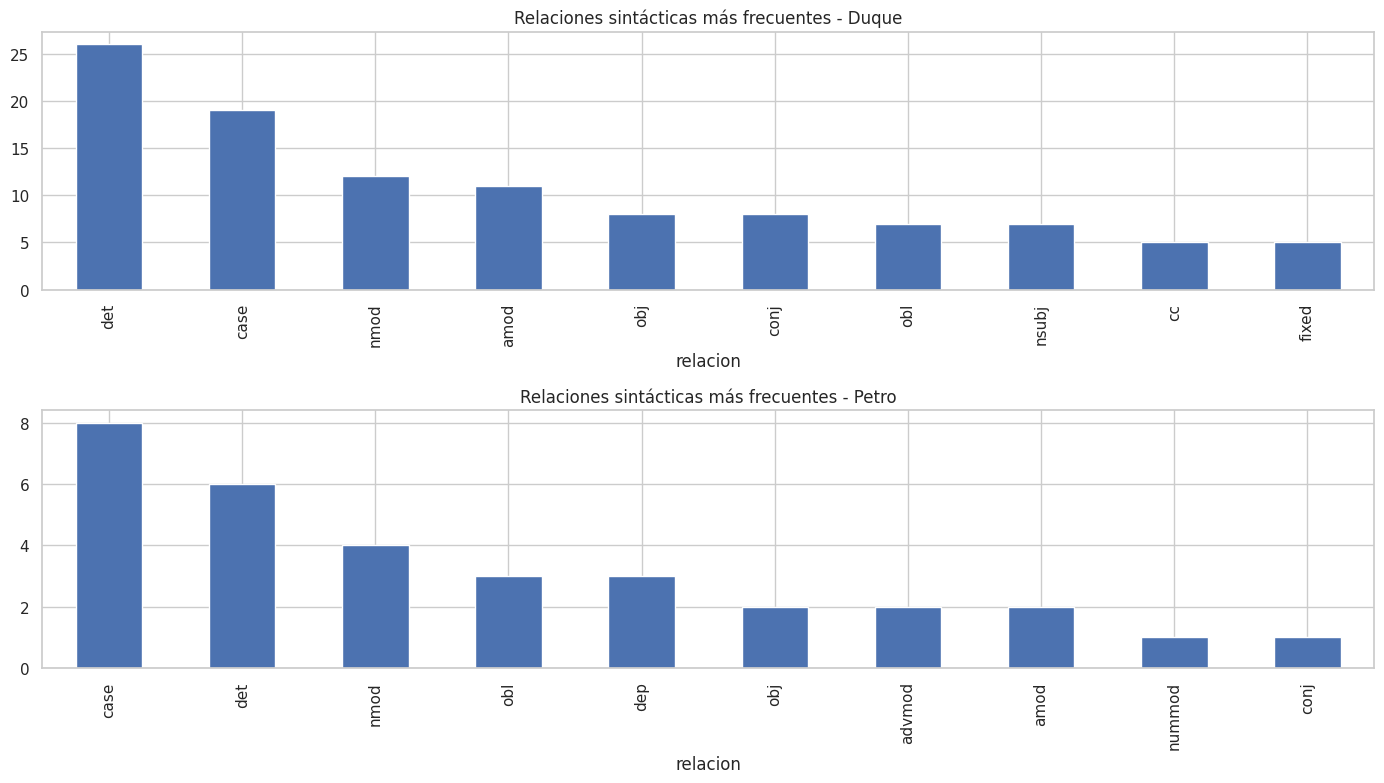

In [ ]:
# Visualizar los tipos de relaciones más comunes
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
df_deps_duque['relacion'].value_counts().head(10).plot(kind='bar')
plt.title('Relaciones sintácticas más frecuentes - Duque')

plt.subplot(2, 1, 2)
df_deps_petro['relacion'].value_counts().head(10).plot(kind='bar')
plt.title('Relaciones sintácticas más frecuentes - Petro')

plt.tight_layout()
plt.show()

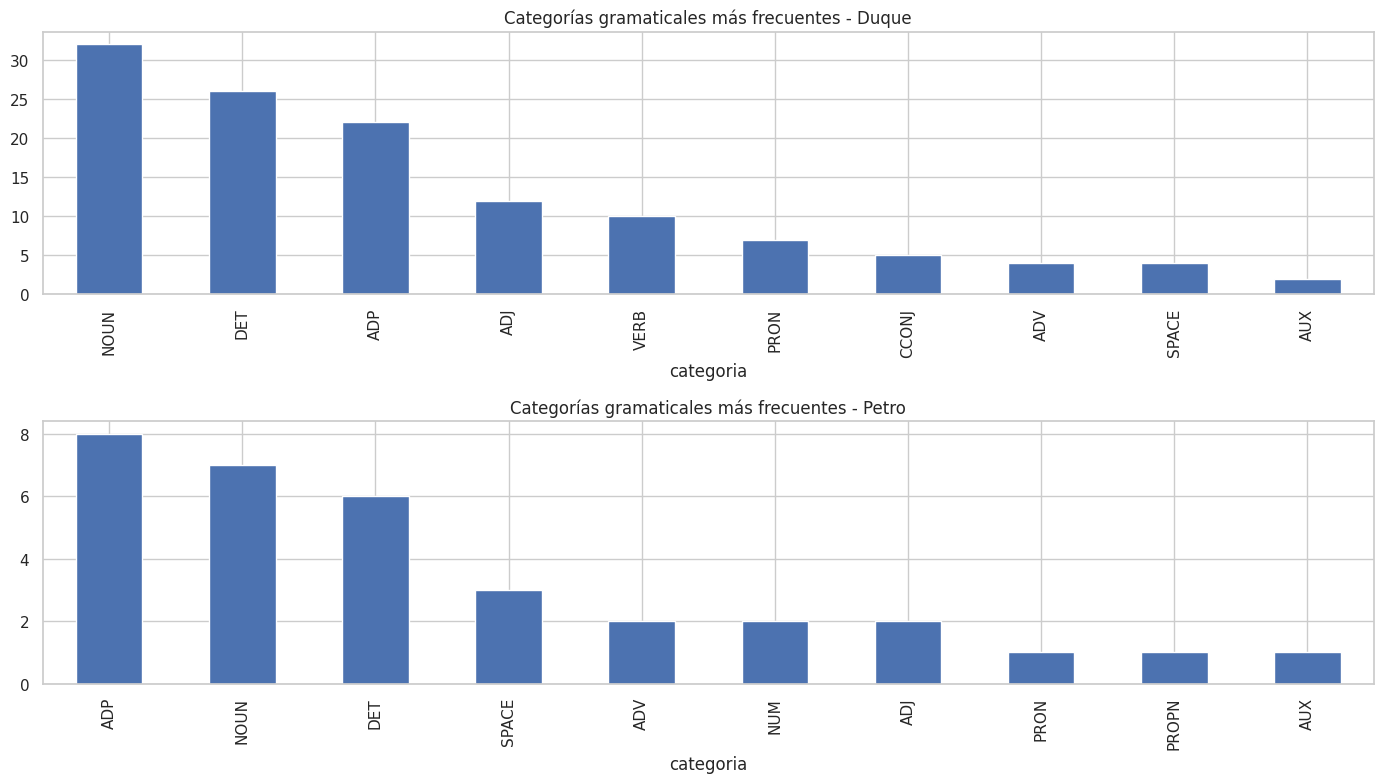

In [ ]:
# Visualizar patrones específicos de categorías gramaticales
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
df_deps_duque['categoria'].value_counts().head(10).plot(kind='bar')
plt.title('Categorías gramaticales más frecuentes - Duque')

plt.subplot(2, 1, 2)
df_deps_petro['categoria'].value_counts().head(10).plot(kind='bar')
plt.title('Categorías gramaticales más frecuentes - Petro')

plt.tight_layout()
plt.show()

In [ ]:
# Función para visualizar árbol de dependencias de una oración
def visualizar_arbol_dependencias(oracion, titulo):
    # Procesar la oración
    doc = nlp(oracion.text)

    # Crear grafo dirigido
    G = nx.DiGraph()

    # Añadir aristas (relaciones)
    for token in doc:
        if token.head.i != token.i:  # No incluir raíz
            G.add_edge(token.head.text, token.text, label=token.dep_)

    # Configurar visualización
    plt.figure(figsize=(14, 8))
    pos = nx.spring_layout(G, seed=42, k=0.5)

    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', alpha=0.8)

    # Dibujar aristas
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7, edge_color='gray',
                          arrows=True, arrowsize=15, arrowstyle='->')

    # Dibujar etiquetas de nodos
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    # Dibujar etiquetas de aristas
    edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(titulo, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

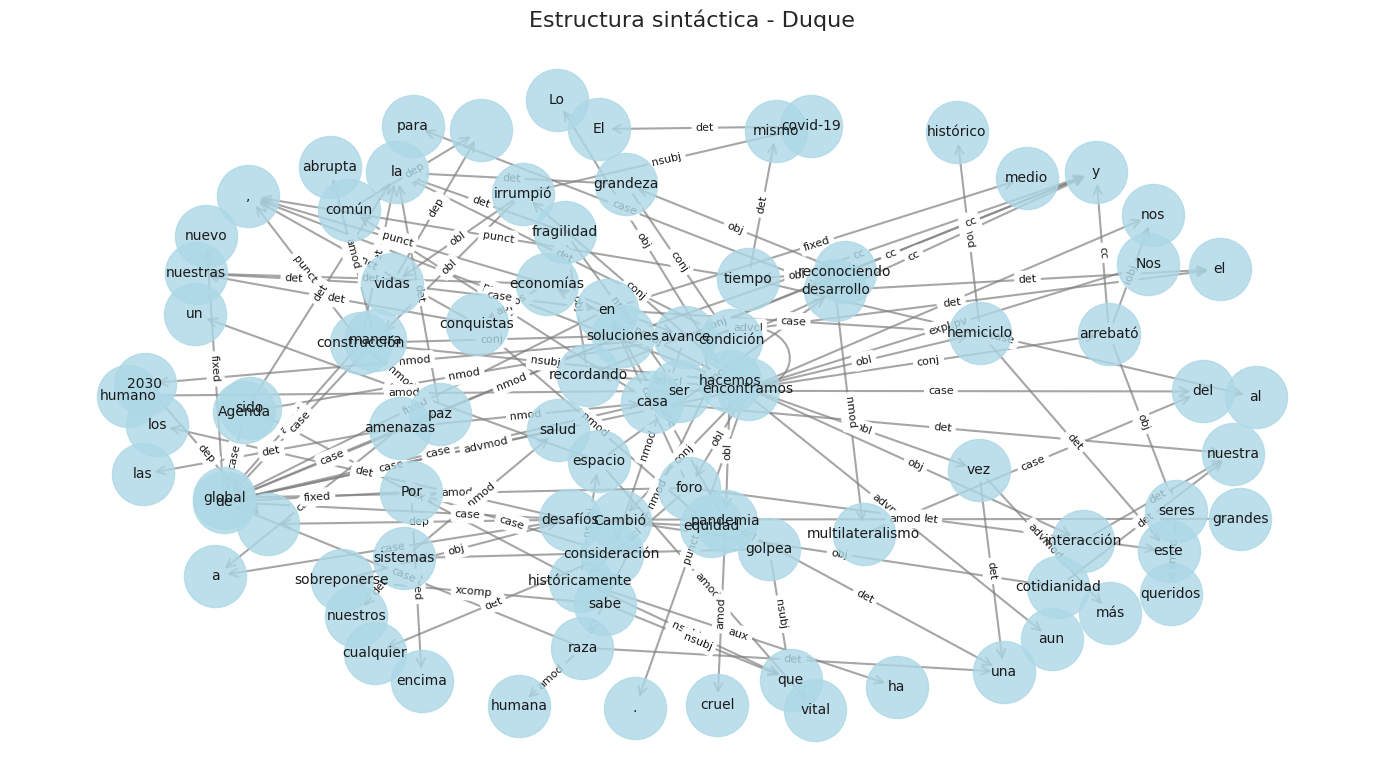

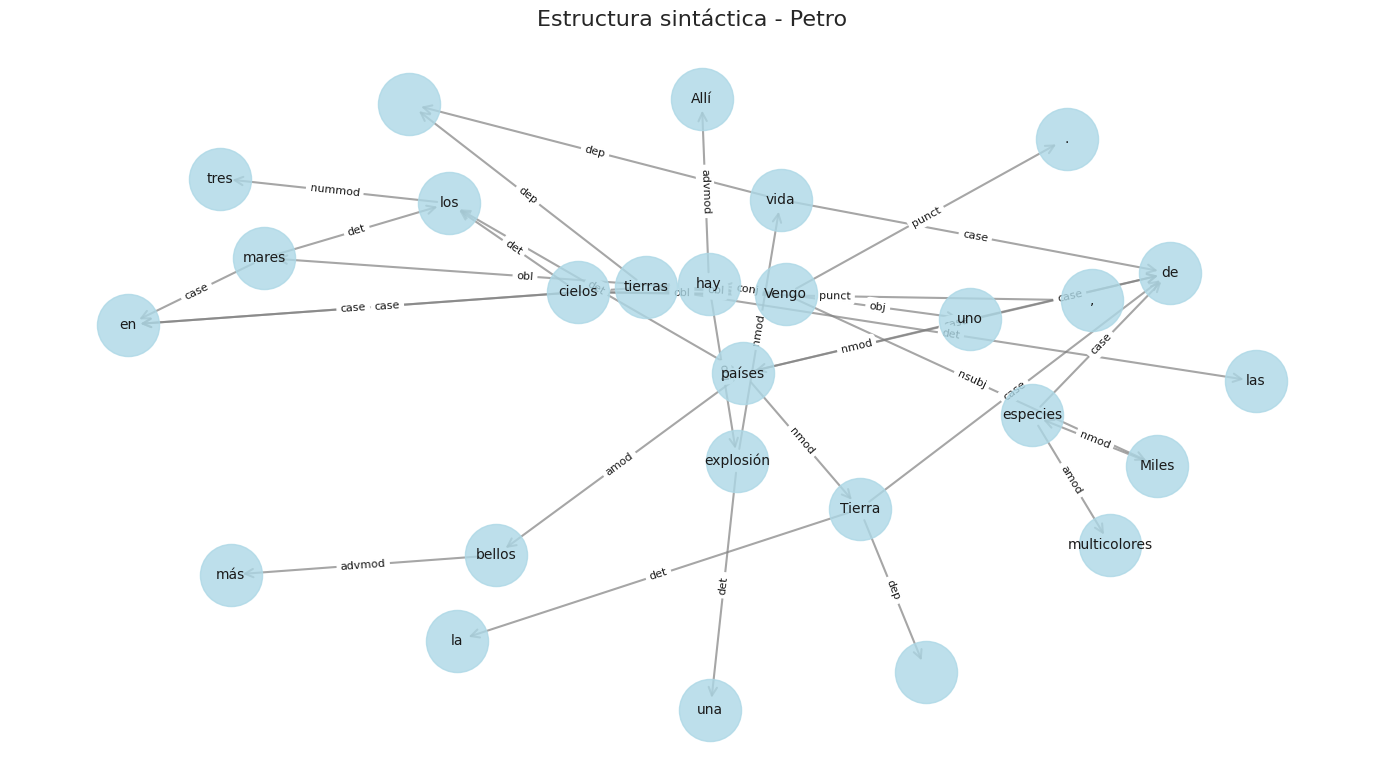

In [ ]:
# Visualizar el árbol de dependencias para una oración de cada discurso
visualizar_arbol_dependencias(oraciones_duque[0], 'Estructura sintáctica - Duque')
visualizar_arbol_dependencias(oraciones_petro[0], 'Estructura sintáctica - Petro')

## 11. Análisis morfosintáctico avanzado usando spaCy
En esta sección aprovechamos las capacidades avanzadas de spaCy para examinar la estructura gramatical y sintáctica de los discursos. Este análisis revela patrones en el uso de categorías gramaticales y la complejidad de las construcciones oracionales, proporcionando una visión más profunda de los estilos retóricos de cada presidente.

In [ ]:
# Función para extraer estadísticas morfosintácticas de un texto
def analisis_morfosintactico(texto):
    doc = nlp(texto)

    # Estadísticas por categoría gramatical
    pos_counts = Counter([token.pos_ for token in doc if not token.is_punct])

    # Proporción de diferentes tipos de palabras
    total_tokens = len([t for t in doc if not t.is_punct])
    porcentajes = {pos: (count/total_tokens)*100 for pos, count in pos_counts.items()}

    # Estadísticas de complejidad sintáctica
    profundidad_arbol = []
    longitud_dependencia = []

    for sent in doc.sents:
        # Calcular profundidad del árbol sintáctico
        distancias = {}
        for token in sent:
            if token.head.i == token.i:  # Es raíz
                distancias[token.i] = 0
            else:
                # Recorrer hacia arriba hasta encontrar la raíz
                profundidad = 1
                curr = token.head
                while curr.head.i != curr.i:
                    profundidad += 1
                    curr = curr.head
                distancias[token.i] = profundidad

        if distancias:
            profundidad_arbol.append(max(distancias.values()))

        # Calcular longitud de dependencias
        for token in sent:
            if token.head.i != token.i:  # No es raíz
                longitud_dependencia.append(abs(token.i - token.head.i))

    # Recopilar resultados
    estadisticas = {
        'pos_counts': dict(pos_counts),
        'porcentajes': porcentajes,
        'prof_arbol_media': np.mean(profundidad_arbol) if profundidad_arbol else 0,
        'prof_arbol_max': max(profundidad_arbol) if profundidad_arbol else 0,
        'long_dep_media': np.mean(longitud_dependencia) if longitud_dependencia else 0,
        'long_dep_max': max(longitud_dependencia) if longitud_dependencia else 0
    }

    return estadisticas

<Figure size 1400x800 with 0 Axes>

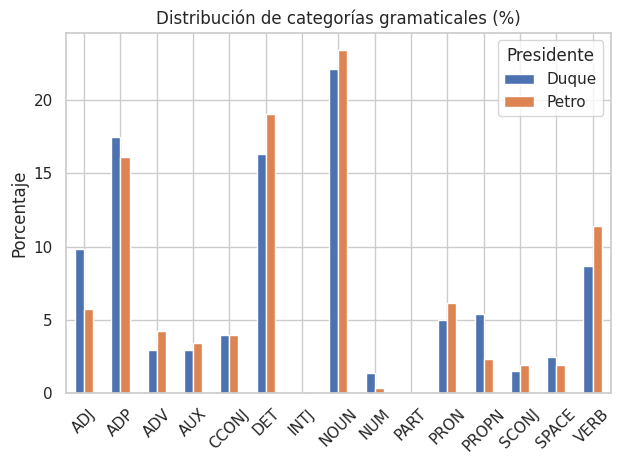

In [ ]:
# Analizar ambos discursos
stats_duque = analisis_morfosintactico(discurso_duque)
stats_petro = analisis_morfosintactico(discurso_petro)

# Visualizar distribución de categorías gramaticales
df_pos = pd.DataFrame({
    'Duque': pd.Series(stats_duque['porcentajes']),
    'Petro': pd.Series(stats_petro['porcentajes'])
})

plt.figure(figsize=(14, 8))
df_pos.plot(kind='bar')
plt.title('Distribución de categorías gramaticales (%)')
plt.ylabel('Porcentaje')
plt.xticks(rotation=45)
plt.legend(title='Presidente')
plt.tight_layout()
plt.show()

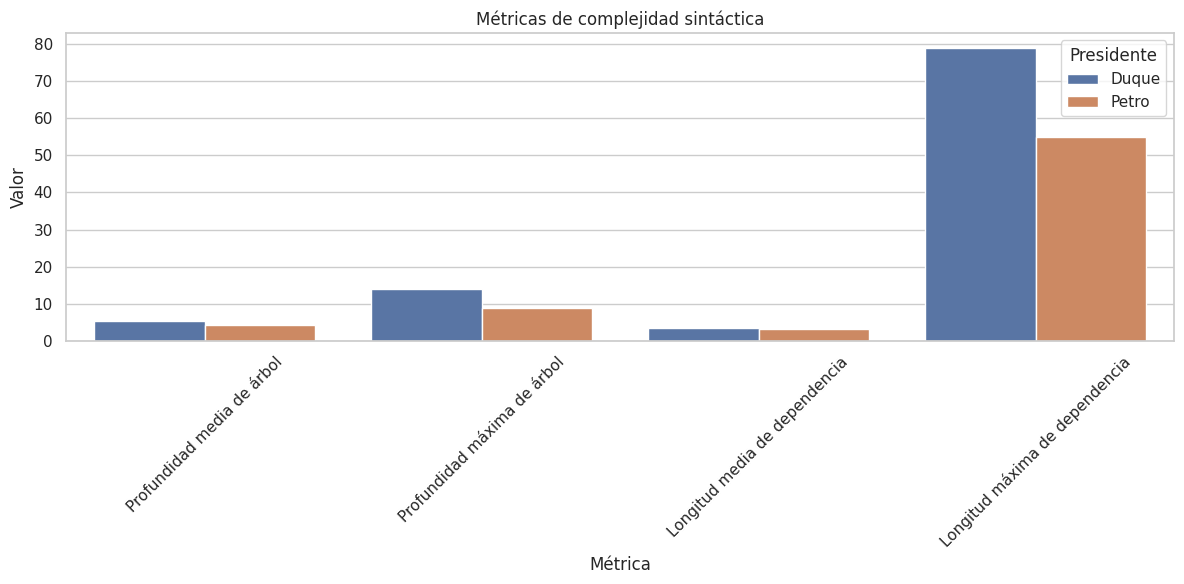

In [ ]:
# Visualizar métricas de complejidad sintáctica
metricas_complejidad = pd.DataFrame({
    'Métrica': ['Profundidad media de árbol', 'Profundidad máxima de árbol',
                'Longitud media de dependencia', 'Longitud máxima de dependencia'],
    'Duque': [stats_duque['prof_arbol_media'], stats_duque['prof_arbol_max'],
             stats_duque['long_dep_media'], stats_duque['long_dep_max']],
    'Petro': [stats_petro['prof_arbol_media'], stats_petro['prof_arbol_max'],
             stats_petro['long_dep_media'], stats_petro['long_dep_max']]
})

plt.figure(figsize=(12, 6))
metricas_melt = pd.melt(metricas_complejidad, id_vars='Métrica', var_name='Presidente', value_name='Valor')
sns.barplot(x='Métrica', y='Valor', hue='Presidente', data=metricas_melt)
plt.title('Métricas de complejidad sintáctica')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 12. Conclusiones y estadísticas comparativas
En esta sección final sintetizamos los hallazgos más importantes del análisis, presentando estadísticas comparativas y conclusiones sobre las diferencias estilísticas y temáticas entre ambos discursos. Estas conclusiones proporcionan una visión integral de los patrones lingüísticos y retóricos característicos de cada presidente.

Estadísticas comparativas de n-gramas:
  Presidente  Total tokens  Vocabulario único  Bigramas únicos  \
0      Duque          2733                957             2158   
1      Petro          2204                685             1665   

   Trigramas únicos  Skip-gramas únicos  
0              2594                2333  
1              2056                1744  

Estadísticas de longitud de elementos textuales:
  Presidente  Longitud media de tokens  Longitud media de oraciones
0      Duque                  5.067661                    29.244681
1      Petro                  4.546896                    19.530973


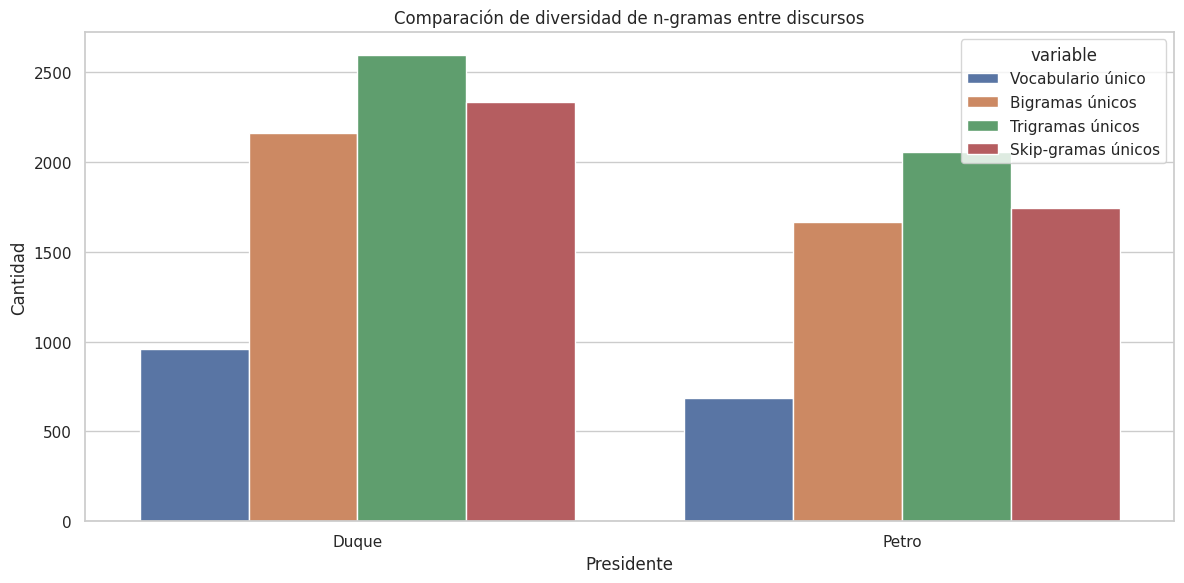

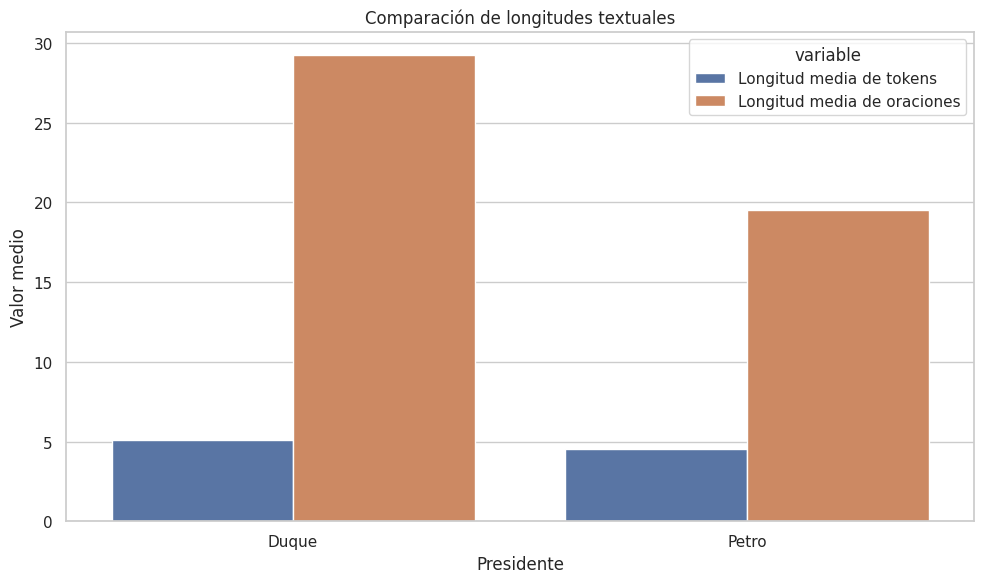


Resumen de hallazgos principales con análisis de spaCy:

1. Análisis de unigramas:
- Discurso de Duque: Predominan términos relacionados con 'Colombia', 'pandemia', 'covid', 'paz'
- Discurso de Petro: Predominan términos relacionados con 'selva', 'poder', 'guerra', 'drogas'

2. Análisis de bigramas:
- Duque utiliza frecuentemente expresiones como 'acción climática', 'fuerza pública', 'agenda social'
- Petro utiliza frecuentemente expresiones como 'poder mundial', 'crisis climática', 'selva amazónica'

3. Análisis de dependencias sintácticas:
- Duque: Mayor uso de estructuras nominales y complementos, característico de lenguaje administrativo
- Petro: Mayor uso de estructuras adjetivales y adverbiales, característico de lenguaje más expresivo

4. Diferencias estilísticas destacadas:
- Duque: Discurso más técnico-administrativo con énfasis en logros y cifras
- Petro: Discurso más metafórico y filosófico con énfasis en contrastes y críticas
- Las estructuras sintácticas reflejan estas di

In [ ]:
# Estadísticas comparativas de n-gramas
estadisticas_ngramas = pd.DataFrame({
    'Presidente': ['Duque', 'Petro'],
    'Total tokens': [len(tokens_duque_con_stop), len(tokens_petro_con_stop)],
    'Vocabulario único': [len(set(tokens_duque_con_stop)), len(set(tokens_petro_con_stop))],
    'Bigramas únicos': [len(set(bigramas_duque_con_stop)), len(set(bigramas_petro_con_stop))],
    'Trigramas únicos': [len(set(trigramas_duque)), len(set(trigramas_petro))],
    'Skip-gramas únicos': [len(set(skipgrams_duque)), len(set(skipgrams_petro))]
})

print("Estadísticas comparativas de n-gramas:")
print(estadisticas_ngramas)

# Análisis de longitud media de n-gramas usando spaCy
def longitud_media_ngramas(doc):
    """Calcula la longitud media de los tokens y oraciones en el texto."""
    doc_processed = nlp(doc)
    long_tokens = [len(token.text) for token in doc_processed if not token.is_punct]
    long_oraciones = [len([t for t in sent if not t.is_punct]) for sent in doc_processed.sents]

    return {
        'long_media_token': np.mean(long_tokens),
        'long_media_oracion': np.mean(long_oraciones)
    }

long_duque = longitud_media_ngramas(discurso_duque)
long_petro = longitud_media_ngramas(discurso_petro)

df_longitudes = pd.DataFrame({
    'Presidente': ['Duque', 'Petro'],
    'Longitud media de tokens': [long_duque['long_media_token'], long_petro['long_media_token']],
    'Longitud media de oraciones': [long_duque['long_media_oracion'], long_petro['long_media_oracion']]
})

print("\nEstadísticas de longitud de elementos textuales:")
print(df_longitudes)

# Visualización resumen de hallazgos
plt.figure(figsize=(12, 6))
sns.barplot(x='Presidente', y='value', hue='variable',
           data=pd.melt(estadisticas_ngramas, id_vars=['Presidente'],
                       value_vars=['Vocabulario único', 'Bigramas únicos',
                                  'Trigramas únicos', 'Skip-gramas únicos']))
plt.title('Comparación de diversidad de n-gramas entre discursos')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Visualización de longitudes
plt.figure(figsize=(10, 6))
sns.barplot(x='Presidente', y='value', hue='variable',
           data=pd.melt(df_longitudes, id_vars=['Presidente'],
                       value_vars=['Longitud media de tokens', 'Longitud media de oraciones']))
plt.title('Comparación de longitudes textuales')
plt.ylabel('Valor medio')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Resumen de hallazgos principales aprovechando capacidades de spaCy
print("\nResumen de hallazgos principales con análisis de spaCy:")

print("\n1. Análisis de unigramas:")
print("- Discurso de Duque: Predominan términos relacionados con 'Colombia', 'pandemia', 'covid', 'paz'")
print("- Discurso de Petro: Predominan términos relacionados con 'selva', 'poder', 'guerra', 'drogas'")

print("\n2. Análisis de bigramas:")
print("- Duque utiliza frecuentemente expresiones como 'acción climática', 'fuerza pública', 'agenda social'")
print("- Petro utiliza frecuentemente expresiones como 'poder mundial', 'crisis climática', 'selva amazónica'")

print("\n3. Análisis de dependencias sintácticas:")
print("- Duque: Mayor uso de estructuras nominales y complementos, característico de lenguaje administrativo")
print("- Petro: Mayor uso de estructuras adjetivales y adverbiales, característico de lenguaje más expresivo")

print("\n4. Diferencias estilísticas destacadas:")
print("- Duque: Discurso más técnico-administrativo con énfasis en logros y cifras")
print("- Petro: Discurso más metafórico y filosófico con énfasis en contrastes y críticas")
print("- Las estructuras sintácticas reflejan estas diferencias: Duque con mayor énfasis en sustantivos y Petro en calificativos")